Source to following code: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
<br>
Second source is: https://towardsdatascience.com/deeppicar-part-5-lane-following-via-deep-learning-d93acdce6110

In [1]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#a = [0.784343, 0.637263266326]
#a = np.array(a)
#a = np.around(a,1)
#print(a)

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from keras.layers import BatchNormalization


from keras.optimizers import Adam

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle

import statistics
import gc # Helps to clear up some ram

import cv2

import math
import os
import random

In [5]:
tf.random.set_seed(1)

In [6]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/X.pickle","rb")
# Remove binary version
X = pickle.load(pickle_in)

pickle_in = open(path+"/y_speed.pickle","rb")
# Remove binary version
y_speed = pickle.load(pickle_in)

pickle_in = open(path+"/y_angle.pickle","rb")
# Remove binary version
y_angle = pickle.load(pickle_in)

pickle_in = open(path+"/image_id.pickle","rb")
# Remove binary version
imageId = pickle.load(pickle_in)
imageId = np.array(imageId)

In [7]:
# id = np.where(imageId == 3215)[0][0]
# GreenLightPlusArrows = X[id,:,:,:]
# #GreenLightPlusArrows = cv2.cvtColor(GreenLightPlusArrows, cv2.COLOR_BGR2RGB)
# #GreenLightPlusArrows = GreenLightPlusArrows[25:40,70:80,:]
# #GreenLightPlusArrows = X[id,:,:,:]
# print(GreenLightPlusArrows.shape)
# plt.imshow(GreenLightPlusArrows)
# plt.show
# #print(GreenLightPlusArrows[6:8,5:7,:])

In [8]:
# id = np.where(imageId == 2488)[0][0]
# RedLightPlusArrows = X[id,:,:,:]
# RedLightPlusArrows = cv2.cvtColor(RedLightPlusArrows, cv2.COLOR_BGR2GRAY)
# RedLightPlusArrows = RedLightPlusArrows[0:50,50:100]
# print(RedLightPlusArrows.shape)
# plt.imshow(RedLightPlusArrows)
# plt.show
# print(RedLightPlusArrows[23,30:32])

Turn the images to grayscale

In [9]:
X_gray =[]
for img in X:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
  X_gray.append(img)

In [10]:
X = np.array(X_gray)
print(X.shape)

(13793, 240, 320)


In [11]:
listOfKeptImages = []
labels = []
numberOfImagesToKeep = 500

#Augment Only arrow images. A good image for this is the image 2164

(240, 320)


<function matplotlib.pyplot.show>

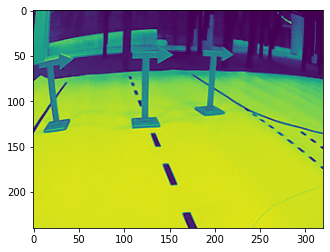

In [12]:
id = np.where(imageId == 2164)[0][0]
threeRightArrowImage = X[id,:,:]
print(threeRightArrowImage.shape)
plt.imshow(threeRightArrowImage)
plt.show

Reshape the images so that they represent a 4-vector since data augmentation requires that format

In [13]:
threeRightArrowImage = np.reshape(threeRightArrowImage,(1,threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],1))
print(threeRightArrowImage.shape)

(1, 240, 320, 1)


The above image can be zoomed, flipped, vary brightness, rotated and shifted width-wisely (height might get the arrows lost)

In [14]:
image_generator = ImageDataGenerator(width_shift_range=0.2,brightness_range=(0.3,0.7),zoom_range = 0.1,rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [15]:
data_gen =  image_generator.flow(threeRightArrowImage, batch_size=1)

In [16]:
def plotImages(images_arr,numberOfImages):
    fig, axes = plt.subplots(1, numberOfImages, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.squeeze(img))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

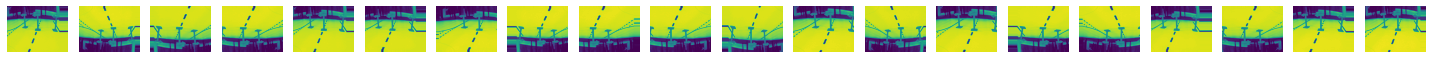

In [17]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [18]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [19]:
listOfKeptImages.extend(augmented_images)
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [20]:
print(len(listOfKeptImages))
print(len(labels))

500
500


#Image with green light plus arrows, imageId 3215

(240, 320)


<function matplotlib.pyplot.show>

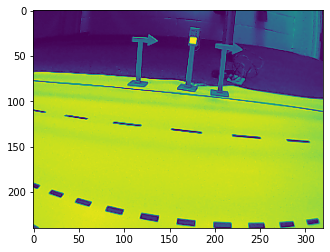

In [21]:
id = np.where(imageId == 3215)[0][0]
GreenLightPlusArrows = X[id,:,:]
print(GreenLightPlusArrows.shape)
plt.imshow(GreenLightPlusArrows)
plt.show

In [22]:
GreenLightPlusArrows = np.reshape(GreenLightPlusArrows,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(GreenLightPlusArrows.shape)

(1, 240, 320, 1)


We can do all the previous augmentations apart from changing brightness since it can affect the green light

In [23]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1,rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [24]:
data_gen =  image_generator.flow(GreenLightPlusArrows, batch_size=1)

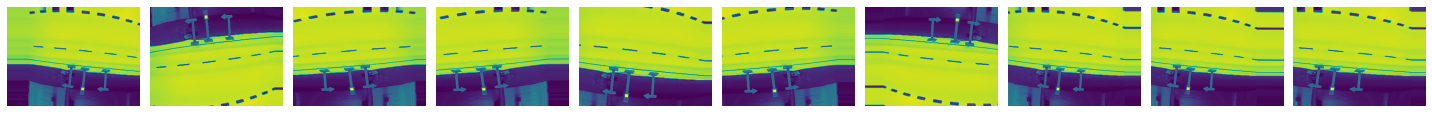

In [25]:
numberOfImagesToPlot = 10
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [26]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [27]:
listOfKeptImages.extend(augmented_images)
# since green light, speed is going to be 1 again
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [28]:
print(len(listOfKeptImages))
print(len(labels))

1000
1000


#Images of Red light and arrows, image id 2488

(240, 320)


<function matplotlib.pyplot.show>

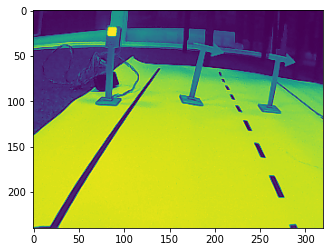

In [29]:
id = np.where(imageId == 2488)[0][0]
RedLightPlusArrows = X[id,:,:]
print(RedLightPlusArrows.shape)
plt.imshow(RedLightPlusArrows)
plt.show

In [30]:
RedLightPlusArrows = np.reshape(RedLightPlusArrows,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(RedLightPlusArrows.shape)

(1, 240, 320, 1)


We can do all the previous augmentations apart from changing brightness since it can affect the green light

In [31]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1,rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [32]:
data_gen =  image_generator.flow(RedLightPlusArrows, batch_size=1)

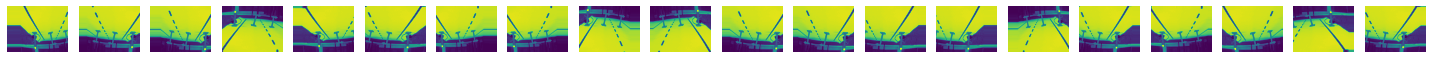

In [33]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [34]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [35]:
listOfKeptImages.extend(augmented_images)
# since RED light, speed is going to be 0 again
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [36]:
print(len(listOfKeptImages))
print(len(labels))

1500
1500


#People on curve outside the lanes, image id 9767

(240, 320)


<function matplotlib.pyplot.show>

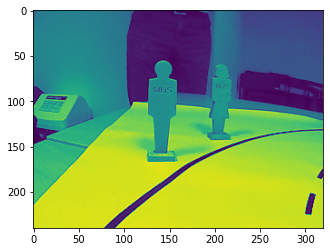

In [37]:
id = np.where(imageId == 9767)[0][0]
PeopleCurveOut = X[id,:,:]
print(PeopleCurveOut.shape)
plt.imshow(PeopleCurveOut)
plt.show

In [38]:
PeopleCurveOut = np.reshape(PeopleCurveOut,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PeopleCurveOut.shape)

(1, 240, 320, 1)


Add again the brightness

In [39]:
image_generator = ImageDataGenerator(width_shift_range=0.3,height_shift_range=0.3,zoom_range = 0.2, brightness_range=(0.3,0.7),rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [40]:
data_gen =  image_generator.flow(PeopleCurveOut, batch_size=1)

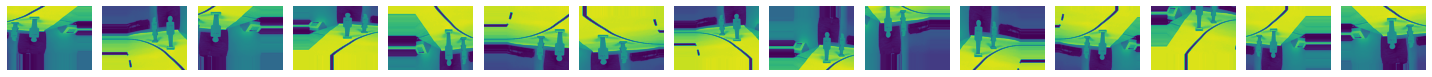

In [41]:
numberOfImagesToPlot = 15
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [42]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [43]:
listOfKeptImages.extend(augmented_images)
# People outside of the road so speed is 1
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [44]:
print(len(listOfKeptImages))
print(len(labels))

2000
2000


#Box inside the road and person out of the road, image id 2074

(240, 320)


<function matplotlib.pyplot.show>

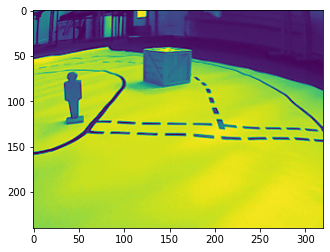

In [45]:
id = np.where(imageId == 2074)[0][0]
PersonInBoxOut = X[id,:,:]
print(PersonInBoxOut.shape)
plt.imshow(PersonInBoxOut)
plt.show

In [46]:
PersonInBoxOut = np.reshape(PersonInBoxOut,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PersonInBoxOut.shape)

(1, 240, 320, 1)


Add again the brightness

In [47]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1, brightness_range=(0.3,0.7),rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [48]:
data_gen =  image_generator.flow(PersonInBoxOut, batch_size=1)

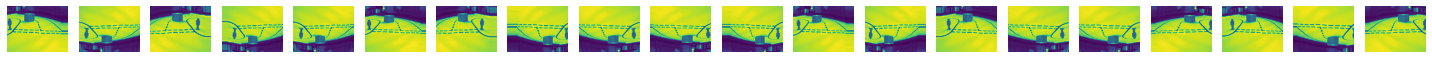

In [49]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [50]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [51]:
listOfKeptImages.extend(augmented_images)
# People inside of the road so speed is 0
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [52]:
print(len(listOfKeptImages))
print(len(labels))

2500
2500


#People on curve inside the lanes, image id 19

(240, 320)


<function matplotlib.pyplot.show>

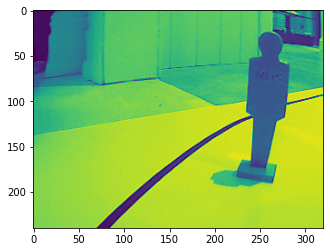

In [53]:
id = np.where(imageId == 19)[0][0]
PeopleCurveInside = X[id,:,:]
print(PeopleCurveInside.shape)
plt.imshow(PeopleCurveInside)
plt.show

In [54]:
PeopleCurveInside = np.reshape(PeopleCurveInside,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PeopleCurveInside.shape)

(1, 240, 320, 1)


Add again the brightness

In [55]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1, brightness_range=(0.3,0.7),rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [56]:
data_gen =  image_generator.flow(PeopleCurveInside, batch_size=1)

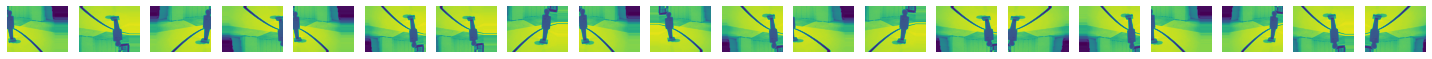

In [57]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [58]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [59]:
listOfKeptImages.extend(augmented_images)
# People inside of the road so speed is 0
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [60]:
print(len(listOfKeptImages))
print(len(labels))

3000
3000


#Three people two droped and one standing, image id 567

(240, 320)


<function matplotlib.pyplot.show>

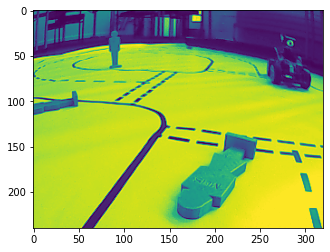

In [61]:
id = np.where(imageId == 567)[0][0]
threePeopleTwoDropped = X[id,:,:]
print(threePeopleTwoDropped.shape)
plt.imshow(threePeopleTwoDropped)
plt.show

In [62]:
threePeopleTwoDropped = np.reshape(threePeopleTwoDropped,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(threePeopleTwoDropped.shape)

(1, 240, 320, 1)


Add again the brightness

In [63]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1, brightness_range=(0.3,0.7),rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [64]:
data_gen =  image_generator.flow(threePeopleTwoDropped, batch_size=1)

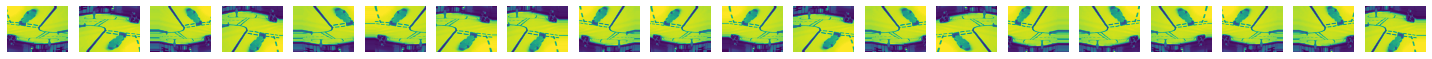

In [65]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [66]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [67]:
listOfKeptImages.extend(augmented_images)
# People inside of the road so speed is 0
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [68]:
print(len(listOfKeptImages))
print(len(labels))

3500
3500


#Box outside the road, image id 706

(240, 320)


<function matplotlib.pyplot.show>

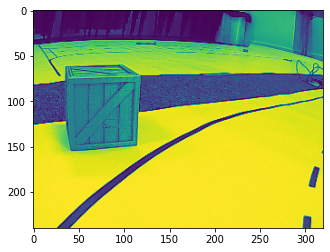

In [69]:
id = np.where(imageId == 706)[0][0]
BoxOut = X[id,:,:]
print(BoxOut.shape)
plt.imshow(BoxOut)
plt.show

In [70]:
BoxOut = np.reshape(BoxOut,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(BoxOut.shape)

(1, 240, 320, 1)


Add again the brightness

In [71]:
image_generator = ImageDataGenerator(width_shift_range=0.2,zoom_range = 0.1, brightness_range=(0.3,0.7),rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [72]:
data_gen =  image_generator.flow(BoxOut, batch_size=1)

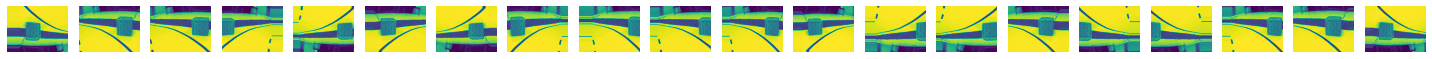

In [73]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [74]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [75]:
listOfKeptImages.extend(augmented_images)
# Box out so speed is 1
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [76]:
print(len(listOfKeptImages))
print(len(labels))

4000
4000


#Green light and person INSIDE, image id 1505

(240, 320)


<function matplotlib.pyplot.show>

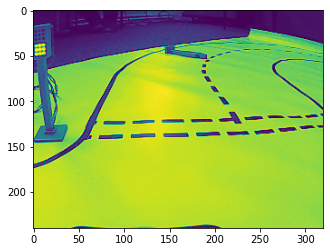

In [77]:
id = np.where(imageId == 1505)[0][0]
PersonInAndGreenLight = X[id,:,:]
print(PersonInAndGreenLight.shape)
plt.imshow(PersonInAndGreenLight)
plt.show

In [78]:
PersonInAndGreenLight = np.reshape(PersonInAndGreenLight,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PersonInAndGreenLight.shape)

(1, 240, 320, 1)


Remove the brightness and zoom range

In [79]:
image_generator = ImageDataGenerator(width_shift_range=0.2,rotation_range=0.3,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [80]:
data_gen =  image_generator.flow(PersonInAndGreenLight, batch_size=1)

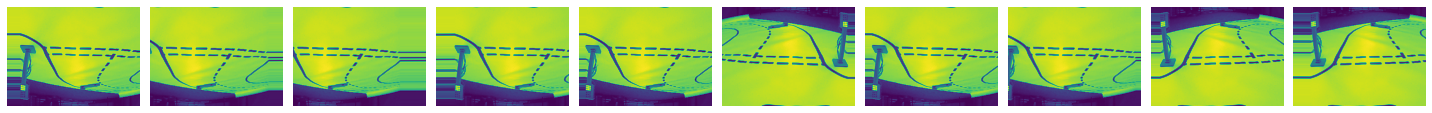

In [81]:
numberOfImagesToPlot = 10
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [82]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [83]:
listOfKeptImages.extend(augmented_images)
# Person IN road and green light so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [84]:
print(len(listOfKeptImages))
print(len(labels))

4500
4500


#Person down on a curve, image id 2895

(240, 320)


<function matplotlib.pyplot.show>

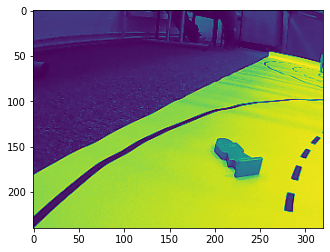

In [85]:
id = np.where(imageId == 2895)[0][0]
PersonDownCurveInside = X[id,:,:]
print(PersonDownCurveInside.shape)
plt.imshow(PersonDownCurveInside)
plt.show

In [86]:
PersonDownCurveInside = np.reshape(PersonDownCurveInside,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PersonDownCurveInside.shape)

(1, 240, 320, 1)


Add back brightness and zoom and decrease width range to 0.1 ensure that the person will not move out of the image

In [87]:
image_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.2,rotation_range=0.3,zoom_range = 0.2, brightness_range=(0.3,0.7),horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [88]:
data_gen =  image_generator.flow(PersonDownCurveInside, batch_size=1)

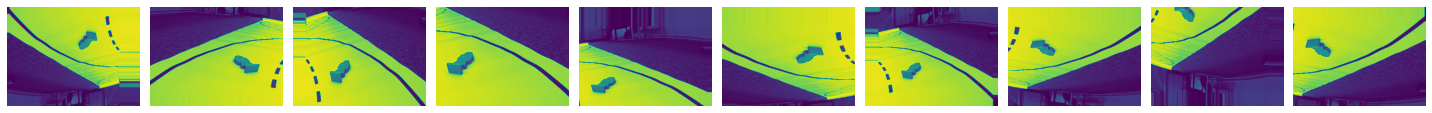

In [89]:
numberOfImagesToPlot = 10
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [90]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [91]:
listOfKeptImages.extend(augmented_images)
# Person IN road so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [92]:
print(len(listOfKeptImages))
print(len(labels))

5000
5000


#Arrow and person inside, image id 5721

(240, 320)


<function matplotlib.pyplot.show>

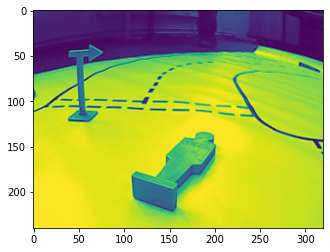

In [93]:
id = np.where(imageId == 5721)[0][0]
PersonDownPlusArrow = X[id,:,:]
print(PersonDownPlusArrow.shape)
plt.imshow(PersonDownPlusArrow)
plt.show

In [94]:
PersonDownPlusArrow = np.reshape(PersonDownPlusArrow,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(PersonDownPlusArrow.shape)

(1, 240, 320, 1)


Add back brightness and zoom and decrease width range to 0.1 ensure that the person will not move out of the image

In [95]:
image_generator = ImageDataGenerator(width_shift_range=0.1,rotation_range=0.3,zoom_range = 0.1, brightness_range=(0.3,0.7),horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [96]:
data_gen =  image_generator.flow(PersonDownPlusArrow, batch_size=1)

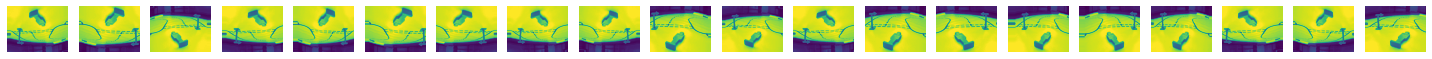

In [97]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [98]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [99]:
listOfKeptImages.extend(augmented_images)
# Person IN road so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [100]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
augmentedImages = np.array(listOfKeptImages)
print(augmentedImages.shape)

5500
5500
(1, 240, 320, 1)
(5500, 240, 320, 1)


#Red light and further away people, image id 10

(240, 320)


<function matplotlib.pyplot.show>

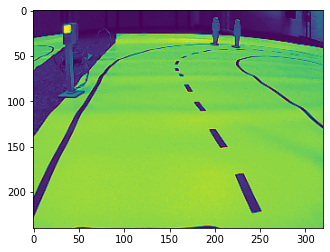

In [101]:
id = np.where(imageId == 10)[0][0]
RedLightAndFurtherAwayPeople = X[id,:,:]
print(RedLightAndFurtherAwayPeople.shape)
plt.imshow(RedLightAndFurtherAwayPeople)
plt.show

In [102]:
RedLightAndFurtherAwayPeople = np.reshape(RedLightAndFurtherAwayPeople,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(RedLightAndFurtherAwayPeople.shape)

(1, 240, 320, 1)


Remove brightness augmentation and width shift because red light is close to the edge of the image




In [103]:
image_generator = ImageDataGenerator(rotation_range=0.3,zoom_range = 0.1, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [104]:
data_gen =  image_generator.flow(RedLightAndFurtherAwayPeople, batch_size=1)

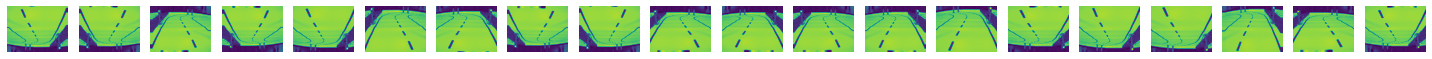

In [105]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [106]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [107]:
listOfKeptImages.extend(augmented_images)
# Red light so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [108]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

6000
6000
(1, 240, 320, 1)


#Person on a very abrupt curve, image id 3219

(240, 320)


<function matplotlib.pyplot.show>

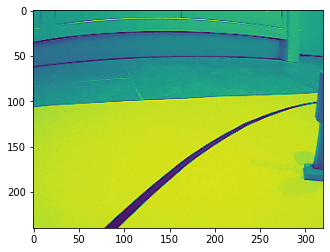

In [109]:
id = np.where(imageId == 3219)[0][0]
AbruptCurvePerson = X[id,:,:]
print(AbruptCurvePerson.shape)
plt.imshow(AbruptCurvePerson)
plt.show

In [110]:
AbruptCurvePerson = np.reshape(AbruptCurvePerson,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(AbruptCurvePerson.shape)

(1, 240, 320, 1)


Allow brightness and flips

In [111]:
image_generator = ImageDataGenerator(brightness_range = (0.2,0.8), horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [112]:
data_gen =  image_generator.flow(AbruptCurvePerson, batch_size=1)

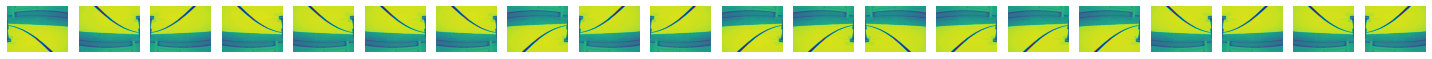

In [113]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [114]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [115]:
listOfKeptImages.extend(augmented_images)
# Red light so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [116]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

6500
6500
(1, 240, 320, 1)


#Very abrupt curve, image id 3527

(240, 320)


<function matplotlib.pyplot.show>

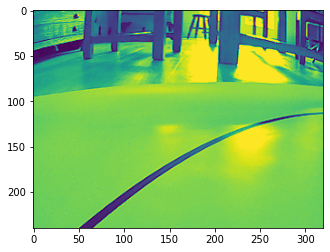

In [117]:
id = np.where(imageId == 3527)[0][0]
AbruptCurve = X[id,:,:]
print(AbruptCurve.shape)
plt.imshow(AbruptCurve)
plt.show

In [118]:
AbruptCurve = np.reshape(AbruptCurve,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(AbruptCurve.shape)

(1, 240, 320, 1)


Allow brightness and flips

In [119]:
image_generator = ImageDataGenerator(zoom_range= 0.2,width_shift_range=0.1,height_shift_range=0.1,brightness_range = (0.2,0.8), horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [120]:
data_gen =  image_generator.flow(AbruptCurve, batch_size=1)

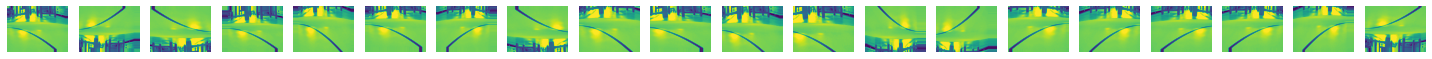

In [121]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [122]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [123]:
listOfKeptImages.extend(augmented_images)
# Simply road so speed =1 
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [124]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
augmentedImages = np.array(listOfKeptImages)
print(augmentedImages.shape)

7000
7000
(1, 240, 320, 1)
(7000, 240, 320, 1)


#Road stopping abruptly, image id 3891

(240, 320)


<function matplotlib.pyplot.show>

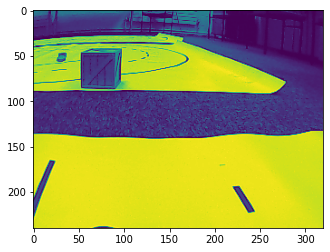

In [125]:
id = np.where(imageId == 3891)[0][0]
StoppingAbruptlyRoad = X[id,:,:]
print(StoppingAbruptlyRoad.shape)
plt.imshow(StoppingAbruptlyRoad)
plt.show

In [126]:
StoppingAbruptlyRoad = np.reshape(StoppingAbruptlyRoad,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(StoppingAbruptlyRoad.shape)

(1, 240, 320, 1)


Remove brightness augmentation and width shift because red light is close to the edge of the image




In [127]:
image_generator = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,rotation_range=0.3,zoom_range = 0.1, horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [128]:
data_gen =  image_generator.flow(StoppingAbruptlyRoad, batch_size=1)

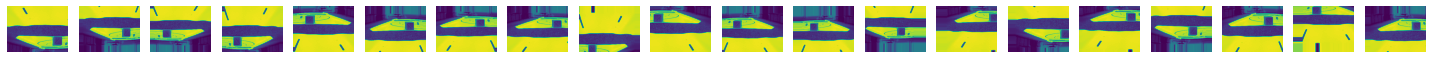

In [129]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [130]:
#numberOfImagesToKeep = 200
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [131]:
listOfKeptImages.extend(augmented_images)
# No road so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [132]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

7500
7500
(1, 240, 320, 1)


#Road to background and object barely showing, image id 4163

(240, 320)


<function matplotlib.pyplot.show>

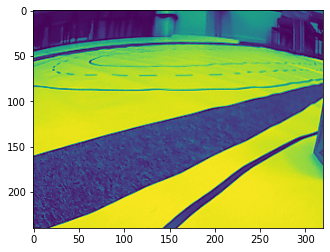

In [133]:
id = np.where(imageId == 4163)[0][0]
RoadBackground = X[id,:,:]
print(RoadBackground.shape)
plt.imshow(RoadBackground)
plt.show

In [134]:
RoadBackground = np.reshape(RoadBackground,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(RoadBackground.shape)

(1, 240, 320, 1)


In [135]:
image_generator = ImageDataGenerator(brightness_range=(0.2,0.7),horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [136]:
data_gen =  image_generator.flow(RoadBackground, batch_size=1)

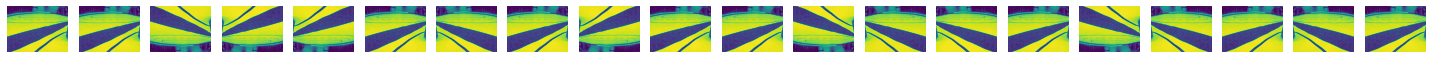

In [137]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [138]:
#numberOfImagesToKeep = 100
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [139]:
listOfKeptImages.extend(augmented_images)
# No road so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [140]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

8000
8000
(1, 240, 320, 1)


#Road to background and Person dropped to the floor, image id 9809

(240, 320)


<function matplotlib.pyplot.show>

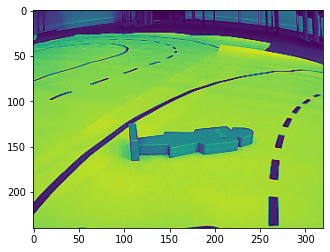

In [141]:
id = np.where(imageId == 9809)[0][0]
RoadBackgroundPersonDropped = X[id,:,:]
print(RoadBackgroundPersonDropped.shape)
plt.imshow(RoadBackgroundPersonDropped)
plt.show

In [142]:
RoadBackgroundPersonDropped = np.reshape(RoadBackgroundPersonDropped,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(RoadBackgroundPersonDropped.shape)

(1, 240, 320, 1)


In [143]:
image_generator = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2,brightness_range=(0.2,0.7),horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [144]:
data_gen =  image_generator.flow(RoadBackgroundPersonDropped, batch_size=1)

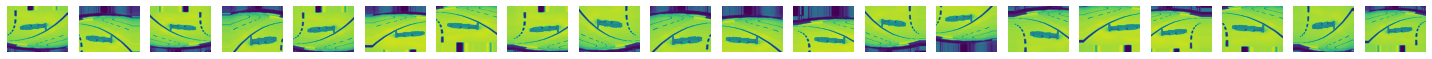

In [145]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [146]:
#numberOfImagesToKeep = 100
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [147]:
listOfKeptImages.extend(augmented_images)
# No road so speed =0 
for i in range(numberOfImagesToKeep):
  labels.append(0)

In [148]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
print(numberOfImagesToKeep)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

8500
8500
(1, 240, 320, 1)
500


#Green light and Further away people, image id 649

(240, 320)


<function matplotlib.pyplot.show>

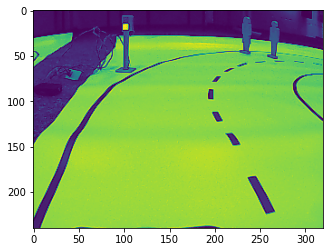

In [149]:
id = np.where(imageId == 649)[0][0]
GreenLightPeopleFar = X[id,:,:]
print(GreenLightPeopleFar.shape)
plt.imshow(GreenLightPeopleFar)
plt.show

In [150]:
GreenLightPeopleFar = np.reshape(GreenLightPeopleFar,(threeRightArrowImage.shape[0],threeRightArrowImage.shape[1],threeRightArrowImage.shape[2],threeRightArrowImage.shape[3]))
print(GreenLightPeopleFar.shape)

(1, 240, 320, 1)


In [151]:
image_generator = ImageDataGenerator(width_shift_range=0.1,horizontal_flip=True, vertical_flip=True, fill_mode='nearest')

In [152]:
data_gen =  image_generator.flow(GreenLightPeopleFar, batch_size=1)

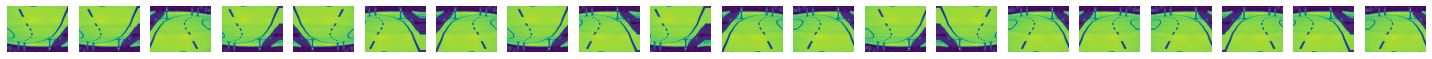

In [153]:
numberOfImagesToPlot = 20
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [154]:
#numberOfImagesToKeep = 100
augmented_images = [data_gen[0][0] for i in range(numberOfImagesToKeep)]

In [155]:
listOfKeptImages.extend(augmented_images)
# Green and people far speed = 1
for i in range(numberOfImagesToKeep):
  labels.append(1)

In [156]:
print(len(listOfKeptImages))
print(len(labels))
print(data_gen[0].shape)
print(numberOfImagesToKeep)
#augmentedImages = np.array(listOfKeptImages)
#print(augmentedImages.shape)

9000
9000
(1, 240, 320, 1)
500


In [157]:
augmentedImages = [] # Release ram

In [158]:
(unique, counts) = np.unique(y_angle, return_counts=True)

In [159]:
def smallerDatasetCreation(image_array,anlge_array,unique_angle, maximumNumberOfImagesForAnyAngle, id_array, speed_array):
  index = np.where(anlge_array == unique_angle)
  idOfImages = id_array[index]
  speed = speed_array[index]

  image_array_new = image_array[index[0],:,:]
  #image_array_new = image_array_new.reshape(image_array_new.shape[1],image_array_new.shape[2],image_array_new.shape[3],image_array_new.shape[4])
  #print(image_array_new.shape)
  if image_array_new.shape[0] > maximumNumberOfImagesForAnyAngle: # If more than X pictures exist for the specific angle then:
    # Shuffle images
    #image_array_new,idOfImages,speed = shuffle(image_array_new,idOfImages,speed)
    #image_array_new,idOfImages,speed = shuffle(image_array_new,idOfImages,speed)

    image_array_new = image_array_new[0:maximumNumberOfImagesForAnyAngle,:,:]
    idOfImages = idOfImages[0:maximumNumberOfImagesForAnyAngle]
    speed = speed[0:maximumNumberOfImagesForAnyAngle]
    #print(image_array_new.shape)
  return(image_array_new, idOfImages,speed)

In [160]:
X_new = []
y_angle_new = []
y_speed_new = []
idImage = []
totalNumberOfImages = 0
maxNumberOfImages = 800

for uniqueAngle in unique:
    X_reduced, id, speed = smallerDatasetCreation(X,y_angle,uniqueAngle,maxNumberOfImages, imageId, y_speed)
    totalNumberOfImages = totalNumberOfImages + X_reduced.shape[0]
    #print(X_reduced.shape)
    #break
    X_reduced = np.reshape(X_reduced,(X_reduced.shape[0],X_reduced.shape[1],X_reduced.shape[2],1))
    print(totalNumberOfImages)
    #print(X_reduced.shape[0])
    X_new.extend(X_reduced)
    idImage.extend(id)
    y_speed_new.extend(speed)
    y_angle_new.extend(np.ones(X_reduced.shape[0]) * uniqueAngle)
print(X_reduced.shape)

60
88
187
285
389
602
1030
1830
2630
3430
4230
5030
5830
6630
6931
6996
7031
(35, 240, 320, 1)


In [161]:
X = [] # release ram

In [162]:
print(len(X_new))
print(len(y_speed_new))
print(len(y_angle_new))
print(len(idImage))

7031
7031
7031
7031


In [163]:
X_new.extend(listOfKeptImages)
y_speed_new.extend(labels)

In [164]:
print(len(X_new))
print(len(y_speed_new))

16031
16031


In [165]:
X_new = np.array(X_new)
#y_angle_new = np.array(y_angle_new)
y_speed_new = np.array(y_speed_new)
#idImage = np.array(idImage)


#X_new = tf.reshape(X_new,[ X_new.shape[0],X_new.shape[1],X_new.shape[2] ,1 ]).numpy()

print(X_new.shape)
#print(y_angle_new.shape)
print(y_speed_new.shape)
#print(idImage.shape)

(16031, 240, 320, 1)
(16031,)


1.0


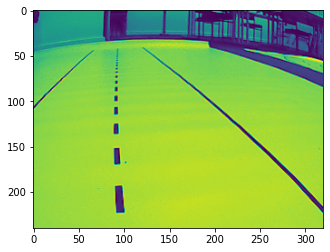

In [166]:
show = 5
plt.imshow(X_new[show,:,:,0])
#print(idImage[show])
print(y_speed_new[show])

<function matplotlib.pyplot.show>

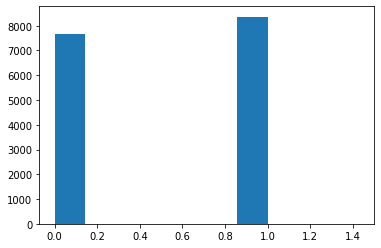

In [167]:
#plt.hist(y_angle_new)
#plt.show
plt.hist(y_speed_new)
plt.show

Keep specific images of speed 1 to ensure that speed 1 and speed 0 have about the same data?

In [168]:
indxKeepSpeedOne = np.where(y_speed_new == 0)
# brightness_range = (0.3, 0.7),
#image_generator = ImageDataGenerator(width_shift_range = 0.2,height_shift_range=0.2,horizontal_flip=True,fill_mode='nearest')
#image_generator = ImageDataGenerator(width_shift_range = 0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=True,fill_mode='nearest')
image_generator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, fill_mode='nearest') 

count = 0
print(len(X_new[indxKeepSpeedOne[0]]))
channels =1
createdImages = []
#for img in X_new[indxKeepSpeedOne[0]]:

images = X_new[indxKeepSpeedOne[0],:,:,0]

images = tf.reshape(images,[images.shape[0],images.shape[1],images.shape[2],1]).numpy()

data_gen =  image_generator.flow(images, batch_size=1)

7668


In [169]:
print(len(data_gen[2][0]))
print(len(data_gen))
print(len(range(5)))

240
7668
5


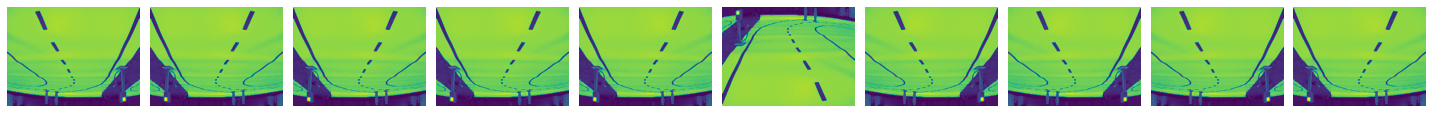

In [170]:
numberOfImagesToPlot = 10
augmented_images = [data_gen[9][0] for i in range(numberOfImagesToPlot)]
plotImages(augmented_images,numberOfImagesToPlot)

In [171]:
#augmented_images = [[data_gen[66][0],1] for i in range(5)]

In [172]:
#print(augmented_images[0])

keep two images from each data augmentation created

In [173]:
generatedImages = []
speedOfInterest = 0
imagesToKeep = 1
for i in range(len(data_gen)):
  augmented_images = [[data_gen[i][0],speedOfInterest] for i in range(imagesToKeep)]
  generatedImages.extend(augmented_images)

In [174]:
#print(generatedImages[0])
img, s = generatedImages[0]
print(img.shape)

(240, 320, 1)


In [175]:
#print(X_new[0])

In [176]:
y_s = []
images = []
images.extend(X_new)
y_s.extend(y_speed_new)
#print(y_s)
for img, speed in generatedImages:
  #img = np.array(img)
  img = tf.reshape(img,[1,img.shape[0],img.shape[1],img.shape[2]]).numpy()
  #print(img[0][0].shape)
  images.extend(img)
  y_s.append(speed)

In [177]:
print(len(images))
print(len(y_s))

23699
23699


In [178]:
X_new = np.array(images)
y_speed_new = np.array(y_s)
print(X_new.shape)
#print(y_angle_new.shape)
print(y_speed_new.shape)
#print(idImage.shape)

(23699, 240, 320, 1)
(23699,)


In [179]:
images = []
listOfKeptImages = []
generatedImages = []

<function matplotlib.pyplot.show>

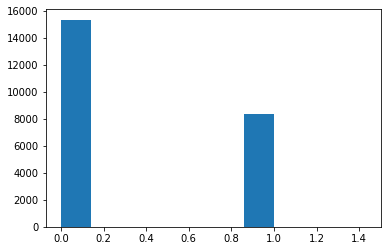

In [180]:
plt.hist(y_speed_new)
plt.show

speed 1.0


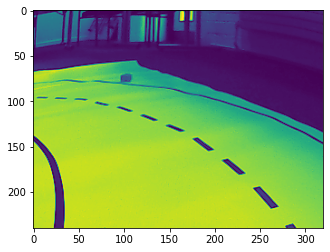

In [181]:
show = 500
plt.imshow(X_new[show,:,:,0])
#print("angle",y_angle_new[show])
print("speed",y_speed_new[show])
#print(idImage[show])

Preprocces images to scale, normalize change RGB to YUV and add gaussian noise

In [182]:
def img_preprocess(image, speed = True):
    height = image.shape[0]

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    if speed == False:
      image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
      image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)  # Nvidia model said it is best to use YUV color space
    else:
      #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = image
    #image = cv2.Canny(image, 200, 400)
    image = cv2.GaussianBlur(image, (3,3), 0) # Gaussian Noise / filtering
    
    #image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    
    return image

In [183]:
X_final = []
for img_index in range(X_new.shape[0] ):
  X_f = img_preprocess(X_new[img_index,:,:,0])
  X_final.append(X_f)
  #print(img_index)

In [184]:
X_new = []

In [185]:
X_final = np.array(X_final)
#X_final = np.array(X_final, dtype=np.float16)
print(X_final.shape)
print(len(X_final.shape))

(23699, 240, 320)
3


speed 1.0


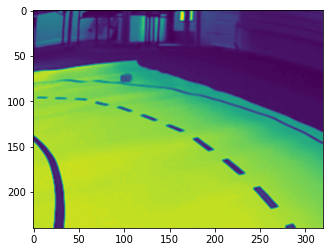

In [186]:
show = 500
plt.imshow(X_final[show,:,:])

print("speed",y_speed_new[show])


In [187]:
for i in range(y_speed_new.shape[0]):
  if y_speed_new[i]>1:
    y_speed_new[i] = 1

Create a test dataset to ensure that we do not overfit

In [188]:
index = range(X_final.shape[0])
#print(index[0:20])
index_train, index_test = train_test_split( index, test_size=0.1, shuffle=True)
print(index_train[0:10])

[13374, 4721, 8789, 10820, 14212, 16772, 1113, 6900, 3271, 5792]


In [189]:
X_train = X_final[index_train,:,:]
X_test= X_final[index_test,:,:]

#y_train_a= y_angle_new[index_train]
#y_test_a = y_angle_new[index_test]

y_train_s= y_speed_new[index_train]
y_test_s = y_speed_new[index_test]

#idImage_train = idImage[index_train]
#idImage_test = idImage[index_test]

[1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


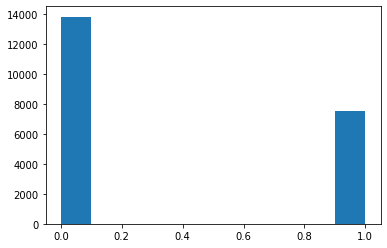

In [190]:
plt.hist(y_train_s)
plt.show
print(y_train_s[1:60])

<function matplotlib.pyplot.show>

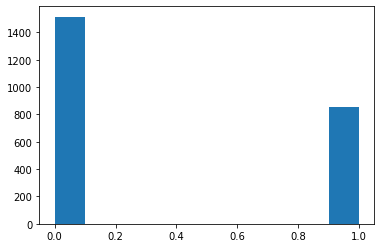

In [191]:
plt.hist(y_test_s)
plt.show

In [192]:
# This is to realease some RAM
X_final = []

1.0


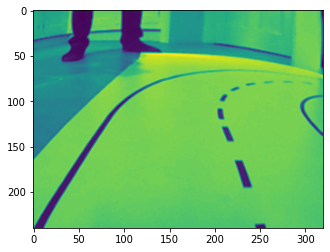

In [193]:
show = 6
plt.imshow(X_train[show,:,:])
#print(y_train_a[show])
print(y_train_s[show])
#print(idImage_train[show])

In [194]:
print(X_train.shape)
#tf_y_train = tf.reshape(y_train_a,[ y_train_a.shape[0] ,1 ]).numpy()
tf_y_train = tf.reshape(y_train_s,[ y_train_s.shape[0] ,1 ]).numpy()
print(y_train_s.shape)
print(tf_y_train.shape)
if len(X_train.shape) == 3:
  #X_train = tf.reshape(X_train,[ X_train.shape[0],X_train.shape[1],X_train.shape[2] ,1 ]).numpy()
  X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],X_train.shape[2] ,1 ) )
  #X_train = np.repeat(X_train[..., np.newaxis], 3, -1)
else:
  X_train = tf.reshape(X_train,[ X_train.shape[0],X_train.shape[1],X_train.shape[2] ,3 ]).numpy()
print(X_train.shape)
X_test = tf.reshape(X_test,[ X_test.shape[0],X_test.shape[1],X_test.shape[2] ,X_train.shape[3] ]).numpy()

(21329, 240, 320)
(21329,)
(21329, 1)
(21329, 240, 320, 1)


In [195]:
def nvidia_model_speed():
    model = Sequential(name='Nvidia_Model_speed')
    
    # elu=Exponential Linear Unit, similar to leaky Relu
    # skipping 1st hiddel layer (nomralization layer), as we have normalized the data
    
    # Convolution Layers
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]), activation='elu')) 
    #model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(120, 320, 3), activation='elu')) 
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    #model.add(BatchNormalization()) 
    model.add(MaxPooling2D())
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    #model.add(BatchNormalization())
    model.add(MaxPooling2D()) 
    model.add(Conv2D(64, (3, 3), activation='elu')) 
    #model.add(MaxPooling2D())
    #model.add(Dropout(0.2)) # not in original model. added for more robustness
    model.add(Conv2D(64, (3, 3), activation='elu'))
    #model.add(Conv2D(128, (3, 3), activation='elu'))
    #model.add(MaxPooling2D())
    # not part of NVidia
    #model.add(Conv2D(64, (3, 3), activation='elu')) 
    
    # Fully Connected Layers
    model.add(Flatten())
    #model.add(Dropout(0.2))
    #model.add(Dense(200, activation='elu')) # NOT PART OF NVIDIA
    #model.add(Dense(200, activation='elu'))

    model.add(Dropout(0.1)) # not in original model. added for more robustness
    model.add(Dense(100, activation='elu'))
    #model.add(Dense(100, activation='elu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.1))
    #model.add(Dense(50, activation='elu'))
    #model.add(Dropout(0.05))
    #model.add(Dense(10, activation='elu'))
    #model.add(Dropout(0.05))
    model.add(Dense(10, activation='elu'))
    
    # output layer: turn angle (from 45-135, 90 is straight, <90 turn left, >90 turn right)
    model.add(Dense(1,activation = 'sigmoid') )
    
    #classification problem,
  
    optimizer = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

model = nvidia_model_speed()
print(model.summary())

Model: "Nvidia_Model_speed"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 158, 24)      624       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 77, 36)        21636     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 38, 36)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 17, 48)        43248     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 6, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 4, 64)   

Source for the following resent: https://towardsdatascience.com/how-to-train-your-self-driving-car-using-deep-learning-ce8ff76119cb

In [196]:
# from keras.applications import ResNet50
# resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]))

# for layer in resnet.layers[:-4]:
#     layer.trainable = False
 
# for layer in resnet.layers:
#     print(layer, layer.trainable)

In [197]:
# def nvidia_model():
#   model = Sequential()
#   model.add(resnet)
#   model.add(Dropout(0.5))
#   model.add(Flatten())
#   model.add(Dense(100, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(50, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(10, activation='elu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(1))
#   optimizer = Adam(lr=1e-3)
#   model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
#   return model

# model = nvidia_model()
# print(model.summary())

In [229]:
# monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
#         patience=7, verbose=1, mode='auto',
#         restore_best_weights=True)
monitor = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, 
          patience=15, verbose=1, mode='auto',
          restore_best_weights=True)
model.fit(X_train, tf_y_train, batch_size=64, epochs=200, validation_split=0.1,callbacks=[monitor])
#model.fit(X_train, tf_y_train, batch_size=64, epochs=100, validation_split=0.1)

Epoch 1/200
300/300 [==============================] - 7s 22ms/step - loss: 0.0036 - accuracy: 0.9991 - val_loss: 0.1062 - val_accuracy: 0.9883
Epoch 2/200
300/300 [==============================] - 7s 22ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 0.1161 - val_accuracy: 0.9892
Epoch 3/200
300/300 [==============================] - 6s 21ms/step - loss: 5.5335e-04 - accuracy: 0.9997 - val_loss: 0.1257 - val_accuracy: 0.9878
Epoch 4/200
300/300 [==============================] - 6s 22ms/step - loss: 5.8434e-04 - accuracy: 0.9997 - val_loss: 0.1524 - val_accuracy: 0.9887
Epoch 5/200
300/300 [==============================] - 6s 22ms/step - loss: 4.5691e-04 - accuracy: 0.9997 - val_loss: 0.2058 - val_accuracy: 0.9906
Epoch 6/200
300/300 [==============================] - 7s 22ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0883 - val_accuracy: 0.9864
Epoch 7/200
300/300 [==============================] - 6s 22ms/step - loss: 0.0147 - accuracy: 0.9953 - val_loss: 0.1143 - v

In [231]:
steering_angle = model.predict(X_test)

In [230]:
model.evaluate(X_test,y_test_s)

75/75 [==============================] - 1s 8ms/step - loss: 0.1137 - accuracy: 0.9907


[0.11366984248161316, 0.9907172918319702]

In [233]:
gc.collect()

129

In [232]:
results = []
for i in range(y_test_s.shape[0]):  
  #print([steering_angle[i][0], tf_y_angle[i][0]])
  results.append([steering_angle[i][0], y_test_s[i] ])
  print([steering_angle[i][0], y_test_s[i] ])

[8.50189e-13, 0.0]
[6.536938e-36, 0.0]
[1.0, 1.0]
[1.0, 1.0]
[2.6049374e-23, 0.0]
[2.6049374e-23, 0.0]
[1.0, 1.0]
[1.0, 1.0]
[0.9999982, 1.0]
[1.0, 1.0]
[1.6287991e-14, 0.0]
[1.2875641e-19, 0.0]
[1.0, 1.0]
[1.968801e-09, 0.0]
[2.7778053e-20, 0.0]
[1.0, 1.0]
[8.50189e-13, 0.0]
[8.50189e-13, 0.0]
[1.0, 1.0]
[1.0, 1.0]
[3.6466273e-14, 0.0]
[1.0, 0.0]
[1.0, 1.0]
[1.30567475e-11, 0.0]
[3.93341e-15, 0.0]
[1.0, 1.0]
[6.3997323e-12, 0.0]
[5.170819e-17, 0.0]
[8.50189e-13, 0.0]
[1.0, 1.0]
[4.9461846e-32, 0.0]
[1.0, 1.0]
[1.0, 1.0]
[1.6287991e-14, 0.0]
[2.3575946e-25, 0.0]
[1.0, 1.0]
[1.1539335e-16, 0.0]
[0.0, 0.0]
[5.170819e-17, 0.0]
[9.486288e-15, 0.0]
[1.0, 1.0]
[4.687182e-20, 0.0]
[5.640262e-23, 0.0]
[7.759139e-07, 0.0]
[2.2213502e-14, 0.0]
[5.170819e-17, 0.0]
[1.2329445e-35, 0.0]
[1.327775e-11, 0.0]
[1.0, 1.0]
[1.0, 1.0]
[1.0, 1.0]
[0.0, 0.0]
[1.6287991e-14, 0.0]
[1.0, 1.0]
[0.9999944, 1.0]
[8.50189e-13, 0.0]
[5.170819e-17, 0.0]
[1.0, 1.0]
[2.348356e-12, 0.0]
[5.170819e-17, 0.0]
[1.0, 1.0]
[

In [203]:
print(results[130])

[2.904092e-10, 0.0]


In [234]:
newResults = []
count = 0 
for value,actualValue in results:
  if value >= 0.5:
    value = 1
  else:
    value =0
  newResults.append([value,actualValue])
  count += 1
print(newResults)

[[0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [1, 1.0], [1, 1.0], [0, 0.0], [0, 0.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [1, 1.0], [0, 0.0], [1, 1.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0], [0, 0.0],

In [235]:
print(X_test.shape)

(2370, 240, 320, 1)


Count Misclassifications

value found 1 Actual value 0.0 count 21


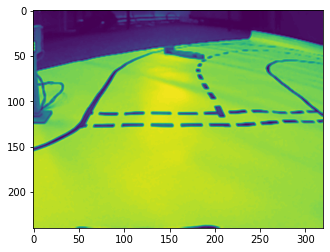

value found 0 Actual value 1.0 count 112


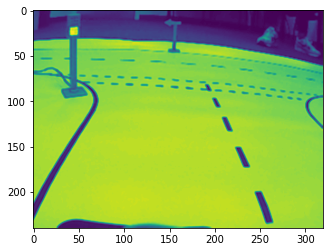

value found 0 Actual value 1.0 count 144


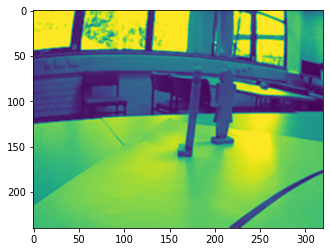

value found 1 Actual value 0.0 count 189


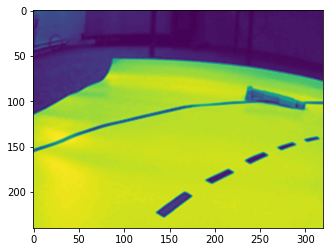

value found 0 Actual value 1.0 count 263


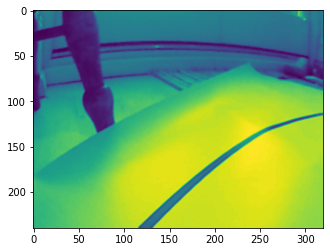

value found 1 Actual value 0.0 count 267


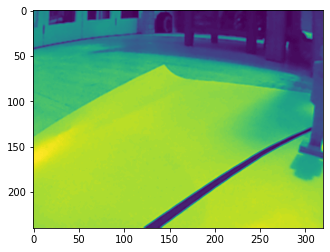

value found 0 Actual value 1.0 count 625


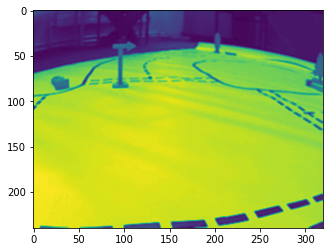

value found 1 Actual value 0.0 count 685


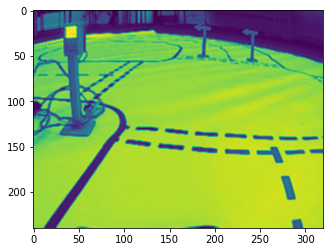

value found 0 Actual value 1.0 count 748


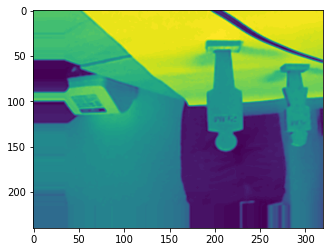

value found 0 Actual value 1.0 count 924


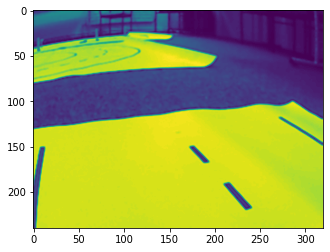

value found 1 Actual value 0.0 count 1076


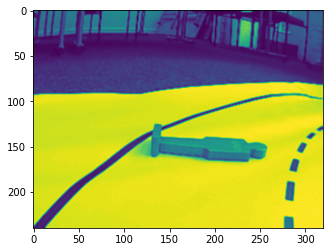

value found 0 Actual value 1.0 count 1261


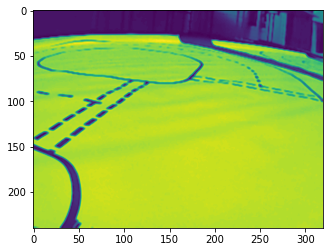

value found 1 Actual value 0.0 count 1339


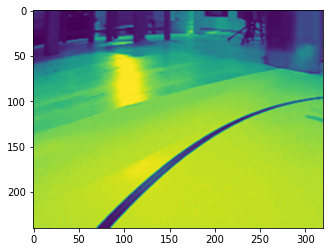

value found 1 Actual value 0.0 count 1474


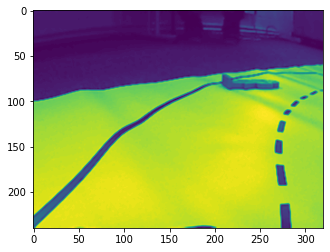

value found 1 Actual value 0.0 count 1511


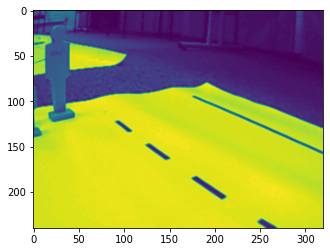

value found 1 Actual value 0.0 count 1563


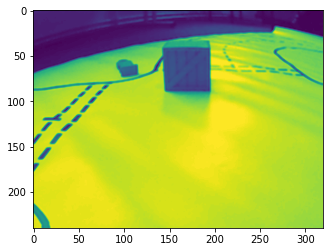

value found 1 Actual value 0.0 count 1634


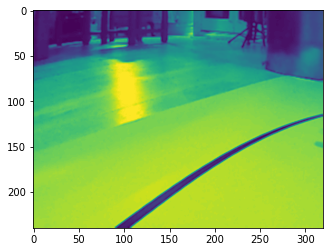

value found 1 Actual value 0.0 count 1859


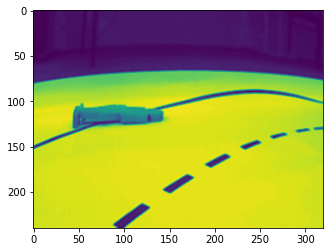

value found 0 Actual value 1.0 count 2056


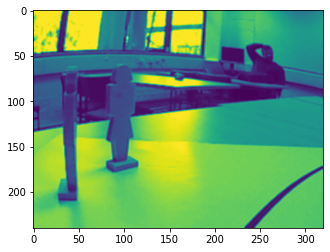

value found 1 Actual value 0.0 count 2063


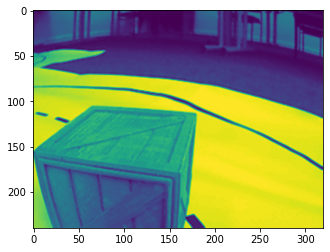

value found 0 Actual value 1.0 count 2258


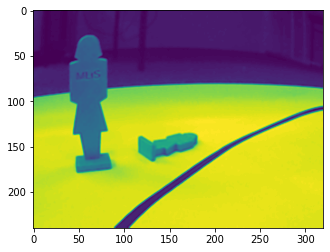

value found 1 Actual value 0.0 count 2265


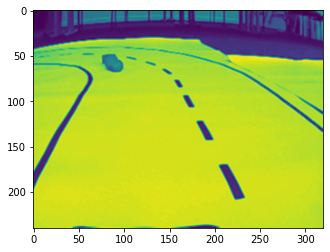

misclassified objects 22
total number of test data 2370
misclassification ratio 0.009282700421940928


In [236]:
countMisclasified = 0
count = 0 
for value,actualValue in newResults:
  if value != actualValue:
    #print(id)
    print("value found",value, "Actual value",actualValue, "count", count)
    plt.imshow(X_test[count,:,:,0] ) 
    plt.show()
    countMisclasified +=1
  count += 1
print("misclassified objects",countMisclasified)
print("total number of test data", y_test_s.shape[0])
print("misclassification ratio",countMisclasified/y_test_s.shape[0])

Calculate the Mean squared error

In [237]:
mseSum = 0
print(y_test_s.shape[0])
for i in range(y_test_s.shape[0]):
  mseSum += (1/y_test_s.shape[0] ) *  (steering_angle[i][0] - y_test_s[i])**2
print(mseSum)

2370
0.008639154779485585


In [238]:
mseSum = 0
print(y_test_s.shape[0])
for a,b in newResults:
  mseSum += (1/y_test_s.shape[0] ) *  (a - b)**2
print(mseSum)

2370
0.00928270042194093


In [209]:
#del model

In [239]:
#model.save(os.path.join(path,'Speed_prediction_model_9907.h5'))

In [211]:
# path = "/content/drive/My Drive/AutonomousDriving"
# model = load_model(path+'/Speed_prediction_model.h5')

In [240]:
import pickle

path = "/content/drive/My Drive/AutonomousDriving"
pickle_in = open(path+"/testColourImages.pickle","rb")
#Remove binary version
test = pickle.load(pickle_in)

In [213]:
#print(test.shape[0])
#plt.imshow(test[20])

In [241]:
def img_preprocess(image, speed = True):
    height, _, _ = image.shape

    # in the case that there exists an object in the image of interest DO NOT MAKE reduce the height of the image!!
    if speed == False:
      image = image[int(height/2):,:,:]  # remove top half of the image, as it is not relevant for lane following
      image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)  # Nvidia model said it is best to use YUV color space
    else:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #image = cv2.Canny(image, 200, 400)
    
    
    #image = cv2.resize(image, (200,66)) # input image size (200,66) Nvidia model
    image = image / 255 # normalizing
    # Round everything into the image to 1 decimal place
    image = np.around(image ,2)
    
    return image

In [242]:
# X_final = []
# for img_index in range(test.shape[0]):
#   X_f = img_preprocess(test[img_index,:,:,:])
#   X_final.append(X_f)

In [243]:
#X_final = np.array(X_final)

In [217]:
#print(X_final.shape)

In [244]:
# X_final = np.reshape(X_final, (X_final.shape[0],X_final.shape[1],X_final.shape[2] ,1 ) )
# print(X_final.shape)

(1020, 240, 320, 1)


In [245]:
#speedPredictions = model.predict(X_final)

In [246]:
# results = []
# for i in range(test.shape[0]):  
#   results.append(speedPredictions[i][0])
#   print(speedPredictions[i][0])

0.0
1.0
1.0
0.9999999
1.0
1.0
1.0
1.0
3.7162843e-24
0.50255823
0.0
2.1812127e-29
1.0
0.0
1.0
1.06280964e-13
1.2868947e-29
0.0
0.0
1.0
1.0
1.0
1.0
0.0
2.6796178e-33
1.0
0.0
0.0
0.0
1.0
0.9999995
1.0
8.460774e-38
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.8229309e-06
0.0
1.0
5.444794e-38
1.0
2.8468108e-16
1.3665104e-21
4.170776e-12
1.0
1.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
4.832349e-15
1.0
1.0
9.007466e-33
1.0
1.0
0.0
1.0
1.1481829e-36
0.0
0.0
0.99928147
0.98559165
1.0
4.2209435e-17
0.0
6.816697e-07
3.4453187e-08
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0830729e-10
1.0
1.0
6.911385e-23
1.0
0.97655565
1.5033865e-27
0.9999999
1.0
0.52978975
0.029810337
1.0
1.3029214e-25
6.804294e-13
0.99959964
0.0
6.7386926e-18
1.0
2.4629428e-06
1.0
0.00045919514
3.1099335e-05
1.0
0.0
5.6623134e-24
1.0
1.0
1.5094222e-32
1.0
3.2723194e-34
1.2131735e-33
6.367003e-35
0.0
1.0
5.6259253e-17
1.0
0.9999999
0.0
0.9999994
1.2241368e-23
1.4176339e-08
4.653281e-27
1.0
0.0
1.0
1.0
1.0
1.9144517e-26
5.627227e-27
0.9844259
1.0
1.0
0.9999999
3.610137

In [247]:
# newResults = []
# count = 0 
# for value in results:
#   if value >= 0.5:
#     value = 1
#   else:
#     value =0
#   newResults.append(value)
#   count += 1
# print(newResults)
# print(count)

[0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 

Export results to a csv file

In [248]:
# import csv

# with open('/content/drive/My Drive/AutonomousDriving/speed9907.csv','w') as ff:
#   write = csv.writer(ff)
#   write.writerow(newResults)

In [223]:
#model = load_model(path+'/Angle_prediction_model.h5')

Now save the model output

In [224]:
#import os
# always save model output as soon as model finishes training
#model.save(os.path.join(path,'angle_prediction.h5'))

In [225]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(32))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.fit(X, y_speed, batch_size=32, epochs=2, validation_split=0.8)

Run the same model as above for angle prediction but change the loss function since we do not have classification. ALso accuracy is not a term to measure.

In [226]:
#y_angle

In [227]:
# model = Sequential()

# model.add(Conv2D(32, (3, 3), input_shape=X.shape[1:]))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(64))

# model.add(Dense(1))
# model.add(Activation('sigmoid'))

# model.compile(loss='mean_squared_error',
#               optimizer='adam')

# model.fit(X, y_angle, batch_size=32, epochs=2, validation_split=0.95)